# Library Import

In [28]:
import numpy as np
import pandas as pd 
import os

In [29]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Recommended for full determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [30]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA Available: True
GPU Name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Load 


In [32]:
# dir= "D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/"

In [33]:
train_dir = 'D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/data/raw/train'
print("Train Direcorty: ",os.listdir(train_dir))
test_dir = 'D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/data/raw/test'
print("test Direcorty: ",os.listdir(test_dir))
val_dir = 'D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/data/raw/valid'
print("val Direcorty: ",os.listdir(val_dir))

Train Direcorty:  ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
test Direcorty:  ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
val Direcorty:  ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


# Custom Data Loader

In [34]:
import os
from torch.utils.data import Dataset
from PIL import Image

class MetalSurfaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir -> path to the train folder
        train/ 
            Crazing/
            Inclusion/
            ...
        """

        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {} # mapping class names to integers

        # Step 1 : Create class index mapping
        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        # Step 2 : iterate through each class folder
        for cls_name in classes:
            cls_folder = os.path.join(root_dir,cls_name)
            label = self.class_to_idx[cls_name]

            # Step 3 : Iterate thrugh each image in one class folder
            for file_name in sorted(os.listdir(cls_folder)):
                file_path = os.path.join(cls_folder, file_name)
                
                # Append image path and corresponding label
                self.image_paths.append(file_path)
                self.labels.append(label)
     
    def __len__(self):
        """ Return total count of images. """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Getting a sample image 
        """
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Apply transforms (resize, normalize, etc.)
        if self.transform:
            img = self.transform(img)

        return img, label

 Defining Data preprocessing

In [35]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean= [0.485,0.456, 0.406],
        std= [0.229,0.224,0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [36]:
train_dataset = MetalSurfaceDataset(
    root_dir= train_dir,
    transform= train_transform
)

val_dataset = MetalSurfaceDataset(
    root_dir= val_dir,
    transform= val_transform
)

test_dataset = MetalSurfaceDataset(
    root_dir= test_dir,
    transform= test_transform
)

In [37]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size= 32,
    shuffle= True,
    num_workers= 0,
    pin_memory= True
)

val_loader = DataLoader(
    val_dataset,
    batch_size= 32,
    shuffle= False,
    num_workers= 0,
    pin_memory= True
)

test_loader = DataLoader(
    test_dataset,
    batch_size= 32,
    shuffle= True,
    num_workers= 0,
    pin_memory= True
)

In [38]:
print(f"Total Number of Train Images : {train_dataset.__len__()}")
print(f"Total Number of Validation Images : {val_dataset.__len__()}")
print(f"Total Number of Test Images : {test_dataset.__len__()}")

Total Number of Train Images : 1656
Total Number of Validation Images : 72
Total Number of Test Images : 72


In [39]:
def show_tensor_image(tensor, title=""):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    img = tensor * std[:, None, None] + mean[:, None, None]
    img = img.permute(1, 2, 0).clamp(0, 1)

    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

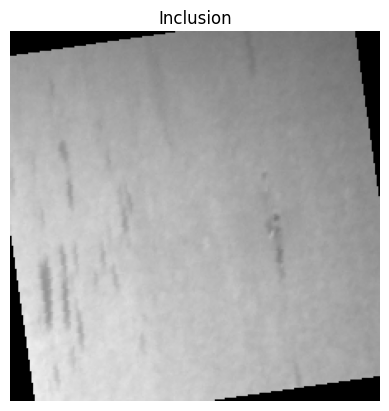

In [40]:
sample_number = 400

idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

image, label = train_dataset.__getitem__(sample_number)

show_tensor_image(image, idx_to_class[label])

# Model Definition

In [41]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes= 6):
        super(CustomCNN, self).__init__()

        # Feature Extractor
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels= 32, kernel_size= 3, stride= 1, padding= 1), # out : 32x224x224
            nn.ReLU(),
            nn.MaxPool2d(2),                                                                   # out : 32x112x112         

            nn.Conv2d(in_channels=32, out_channels= 64, kernel_size= 3, stride= 1, padding= 1), # out : 64x112x112
            nn.ReLU(),
            nn.MaxPool2d(2),                                                                   # out : 64x56x56

            nn.Conv2d(in_channels=64, out_channels= 128, kernel_size= 3, stride= 1, padding= 1), # out : 128x56x56
            nn.ReLU(),
            nn.MaxPool2d(2),                                                                   # out : 128x28x28
        )

        # Fully Connected layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*28*28, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

In [42]:
from torchsummary import summary

temp_model = CustomCNN(num_classes= 6).to(device)
summary(temp_model, input_size= (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
          Flatten-10               [-1, 100352]               0
           Linear-11                  [-1, 256]      25,690,368
             ReLU-12                  [-1, 256]               0
           Linear-13                    [-1, 6]           1,542
Total params: 25,785,158
Trainable para

# Model Training

In [43]:
import torch.optim as optim
from tqdm import tqdm

In [44]:
model = CustomCNN(num_classes= 6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 1e-3)

In [45]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        labels = labels.to(device)

        # Zeroing the gradient from last batch
        optimizer.zero_grad()

        # Forward Pass
        outputs = model(images)

        # Compute Loss
        loss = criterion(outputs, labels)

        # Backward Pass 
        loss.backward()

        # Update weights
        optimizer.step()

        # Tract Metrics 
        running_loss += loss.item() * images.size(0)

        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total 

    print(f"Epoch {epoch+1} / {num_epochs} | Loss : {epoch_loss} | Accuracy : {epoch_acc}")

Epoch 1/10: 100%|██████████| 52/52 [00:08<00:00,  6.08it/s]


Epoch 1 / 10 | Loss : 1.4726040458333665 | Accuracy : 0.5108695652173914


Epoch 2/10: 100%|██████████| 52/52 [00:08<00:00,  6.44it/s]


Epoch 2 / 10 | Loss : 0.5515962297789716 | Accuracy : 0.8085748792270532


Epoch 3/10: 100%|██████████| 52/52 [00:08<00:00,  6.49it/s]


Epoch 3 / 10 | Loss : 0.4150061713900543 | Accuracy : 0.8532608695652174


Epoch 4/10: 100%|██████████| 52/52 [00:08<00:00,  5.79it/s]


Epoch 4 / 10 | Loss : 0.2816414568879178 | Accuracy : 0.9039855072463768


Epoch 5/10: 100%|██████████| 52/52 [00:08<00:00,  6.40it/s]


Epoch 5 / 10 | Loss : 0.2559702372637348 | Accuracy : 0.9106280193236715


Epoch 6/10: 100%|██████████| 52/52 [00:08<00:00,  6.48it/s]


Epoch 6 / 10 | Loss : 0.1770727191714273 | Accuracy : 0.9444444444444444


Epoch 7/10: 100%|██████████| 52/52 [00:07<00:00,  6.52it/s]


Epoch 7 / 10 | Loss : 0.16532650820299047 | Accuracy : 0.9402173913043478


Epoch 8/10: 100%|██████████| 52/52 [00:08<00:00,  6.41it/s]


Epoch 8 / 10 | Loss : 0.1362967085507181 | Accuracy : 0.9480676328502415


Epoch 9/10: 100%|██████████| 52/52 [00:08<00:00,  6.39it/s]


Epoch 9 / 10 | Loss : 0.14025166044056703 | Accuracy : 0.9535024154589372


Epoch 10/10: 100%|██████████| 52/52 [00:08<00:00,  6.44it/s]

Epoch 10 / 10 | Loss : 0.15504349116685887 | Accuracy : 0.947463768115942


In [49]:
torch.save(model.state_dict(), "D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/models/model.pth")

# Model Testing

# Model Training

Model definition

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

d:\Coding Projects\GitHub Projects\metal-surface-defect-classification\env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 199, 199, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 98, 98, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,917,734 (72.17 MB)

 Trainable params: 18,917,734 (72.17 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print('Compiled!')

Compiled!


In [21]:
callbacks = myCallback()
history = model.fit(train_generator,
        batch_size = 32,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[callbacks],
        verbose=1, shuffle=True)

NameError: name 'myCallback' is not defined

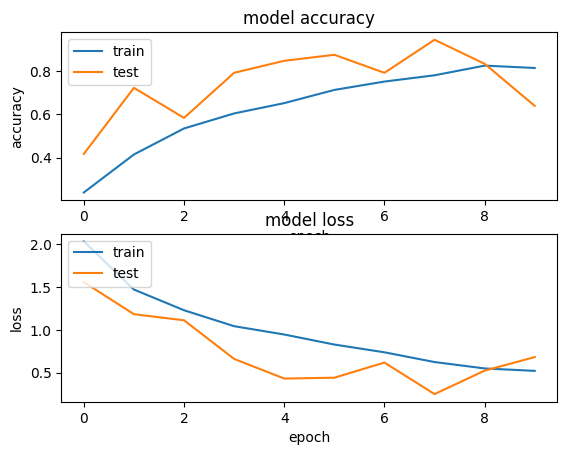

In [ ]:
plt.figure(1)  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()


# Test Result visualization

In [ ]:
print(test_dir)

D:/Coding Projects/GitHub Projects/Metal Surface Defects Classifications/Metal-Surface-Defects-Classification/Dataset/test


In [ ]:
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_test, y_test,target_labels = load_dataset(test_dir)

In [ ]:
no_of_classes = len(np.unique(y_test))
no_of_classes

6

In [ ]:
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_test, num_classes=no_of_classes)

In [ ]:
# We just have the file names in the x set. Let's load the images and convert them into array.
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Test set shape :  (72, 200, 200, 3)


In [ ]:
x_test = x_test.astype('float32')/255

In [ ]:
# Let's visualize test prediction.

y_pred = model.predict(x_test)

# plot a raandom sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

NameError: name 'model' is not defined